In [1]:
# Project: Finding the shortest cycling path between starting point and endpoint

# The below code enables the user to find the shortest path between the entered starting point and endpoint.
# To read and retrieve routable networks for cycling in OpenStreetmap street network, OSMnx's graph_from_place() function is used.
# User must select first the area by providing area name, city and country. Place name must exist in the OpenStreetMap database 
# (test can be run at openstreetmap.org or nominatim.openstreetmap.org). 

# After the entered area is found and returned, user can enter start point and end point. Based on the entered points program
# is finding the shortest path that is presented on interactive map with its length.

In [2]:
import pathlib
import pandas as pd
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "Documents" / "Automating GIS" 

In [3]:
# Retrieving routable networks from OpenStreetMap for cycling in Brno-Bystrc area
import osmnx

print("Enter the area data in the following format:\n'area name, city, country'\nexample: 'Bystrc, Brno, Czechia'")

while True:
    PLACE_NAME = input()
    try:
        graph = osmnx.graph_from_place(
            PLACE_NAME,
            network_type = "bike")
        break
    except ValueError:
        print(f"No results for query {PLACE_NAME} returned. Please try again.\n")

Enter the area data in the following format:
'area name, city, country'
example: 'Bystrc, Brno, Czechia'


 'Bystrc, Brno, Czechia'


In [4]:
# Getting the place boundary of Brno-Bystrc district as a geodataframe
selected_area = osmnx.geocode_to_gdf(PLACE_NAME)

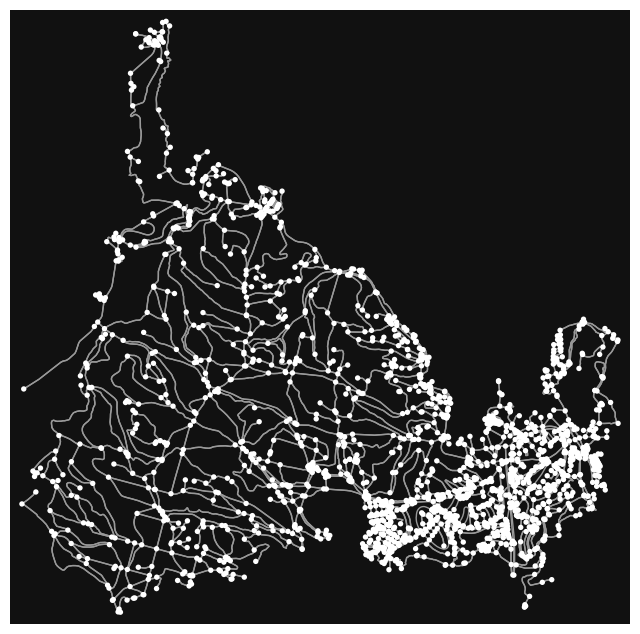

In [5]:
# Fetchning the area of interest in case the shortest path is not completely inside its boundaries

# Re-projecting the polygon to a local projected CRS (so that the CRS unit is meters)
selected_area = selected_area.to_crs("EPSG:5514")

# Buffering by 200 meters
selected_area["geometry"] = selected_area.buffer(200)

# Re-projecting the polygon back to WGS84 (as required by OSMnx)
selected_area = selected_area.to_crs("EPSG:4326")

# Retrieving the network graph
graph = osmnx.graph_from_polygon(
    selected_area.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

In [6]:
# Retrieving edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid lanes   ref   
u        v          key                                      
21378454 5094713411 0                461759633     2  3846  \
         5784558360 0                 36945583   NaN   NaN   
         676025367  0                 53500252   NaN   NaN   
         21378457   0                137992079     2  3846   
21378457 28122241   0    [1147319959, 8315207]   NaN   NaN   

                                         name       highway maxspeed  oneway   
u        v          key                                                        
21378454 5094713411 0                Bystrcká      tertiary       50   False  \
         5784558360 0                 Palcary  unclassified      NaN   False   
         676025367  0                     NaN       service      NaN   False   
         21378457   0    U Zoologické zahrady      tertiary       50   False   
21378457 28122241   0                     NaN       service      NaN   False   

                        reversed   length width   
u        v          key                           
21378454 5094713411 0       True   11.259   NaN  \
         5784558360 0       True   56.318   6.2   
         676025367  0      False   61.009   NaN   
         21378457   0      False  137.174   NaN   
21378457 28122241   0      False   63.140   NaN   

                                                                  geometry   
u        v          key                                                      
21378454 5094713411 0    LINESTRING (16.53451 49.22693, 16.53457 49.22684)  \
         5784558360 0    LINESTRING (16.53451 49.22693, 16.53460 49.226...   
         676025367  0    LINESTRING (16.53451 49.22693, 16.53443 49.226...   
         21378457   0    LINESTRING (16.53451 49.22693, 16.53392 49.227...   
21378457 28122241   0    LINESTRING (16.53386 49.22809, 16.53376 49.228...   

                               service junction bridge access tunnel  
u        v          key                                               
21378454 5094713411 0              NaN      NaN    NaN    NaN    NaN  
         5784558360 0              NaN      NaN    NaN    NaN    NaN  
         676025367  0    parking_aisle      NaN    NaN    NaN    NaN  
         21378457   0              NaN      NaN    NaN    NaN    NaN  
21378457 28122241   0              NaN      NaN    NaN    NaN    NaN

In [7]:
# As the network's data CRS is WGS84, distances are recorded and expressed in degrees,
# areas are expressed in square-degrees. System must be transformed to UTM, so that the distances
# are expressed in meters and network data are convenient for finding a shortest path analysis.

# Transform the graph to UTM 
graph = osmnx.project_graph(graph)
nodes, edges = osmnx.graph_to_gdfs(graph)
nodes.crs

<Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# Defining starting point and endpoint for finding the shortest path
print("Enter starting point name in selected area:\n'Point name or street address, area, city'\nexample: 'Přístaviště, Bystrc, Brno'")

while True:
    origin_name = input()
    try:
        origin = (
            osmnx.geocode_to_gdf(origin_name, which_result=1)  # fetch geolocation
            .to_crs(edges.crs)  # transform to UTM
            .at[0, "geometry"]  # pick geometry of first row
            .centroid  # use the centre point
        )
        break
    except ValueError:
        print(f"No results for query {origin_name} returned. Please try again.\n")

print("\nEnter endpoint name in selected area in the following format:\n'Point name or street address, area, city'\nexample: 'Veveří, Bystrc, Brno'")

while True:
    destination_name = input()
    try:
        destination = (
            osmnx.geocode_to_gdf(destination_name, which_result=1)
            .to_crs(edges.crs)
            .at[0, "geometry"]
            .centroid
        )
        break
    except ValueError:
        print(f"No results for query {destination_name} returned. Please try again.\n")

Enter starting point name in selected area:
'Point name or street address, area, city'
example: 'Přístaviště, Bystrc, Brno'


 'Přístaviště, Bystrc, Brno'



Enter endpoint name in selected area in the following format:
'Point name or street address, area, city'
example: 'Veveří, Bystrc, Brno'


 'Veveří, Bystrc, Brno'


In [9]:
# Finding the nearest node's ID that is part of the network
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

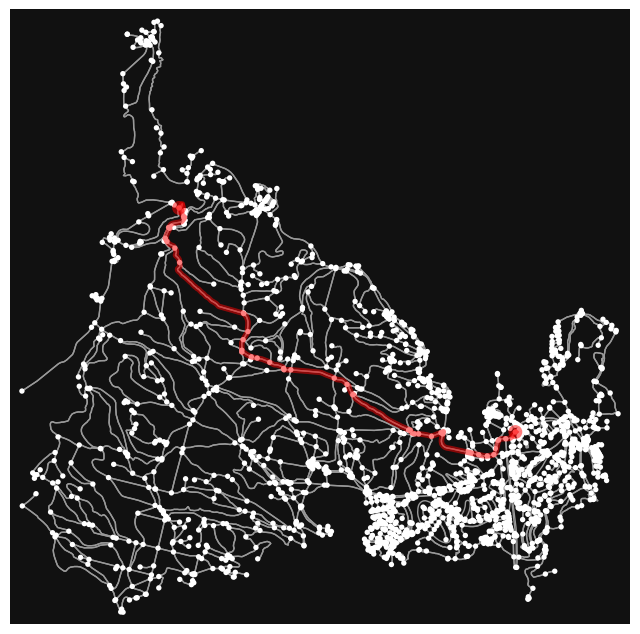

In [10]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)

# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

In [13]:
# Getting the nodes along the shortest path
route_nodes = nodes.loc[route]

# Creating a LineString out of the Point geometries of the nodes
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)

#Creating GeoDataFrame out of route LineString and nodes
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    }, crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length
length = route_geom["length_m"]

In [14]:
import folium
import shapely

# Finding the LineString centroid
route_geom = route_geom.to_crs("EPSG:5514")
center = route_geom["geometry"].centroid

# Re-projecting the system to WGS84 (as required for folium)
center = center.to_crs("EPSG:4326")
route_geom = route_geom.to_crs("EPSG:4326")

# Creating list of center coordinates
coords_list = list(center.geometry.iloc[0].coords)
xycoords = list(coords_list[0])

# Creating list of route_geom points
points = route_geom.geometry.map(lambda LineString: shapely.ops.transform(lambda x, y: (y, x), LineString))
points_coords = list(points.geometry.iloc[0].coords)

# Interactive map
interactive_map = folium.Map(
    location=(xycoords[1], xycoords[0]),
    zoom_start=13,
    control_scale=True, tiles="OpenStreetMap"
)

# Adding selected route to interactive map
folium.PolyLine(points_coords, color="red", weight=4, opacity=0.6, dash_array='8').add_to(interactive_map)

# Adding starting and endpoint to the interactive map
start = points_coords[0]
end = points_coords[-1]

# Adding distance length to pop-up
length_m = route_geom["length_m"]
length = round(length_m[0]/1000)

folium.Marker(location=start, tooltip=f"<b>start</b><br>length: {length} km",icon=folium.Icon(color="green", prefix="fa", icon="bicycle"),
             popup=f"{origin_name}").add_to(interactive_map)
folium.Marker(location=end, tooltip="<b>finish</b>",icon=folium.Icon(color="red", prefix="fa", icon="bicycle"),
             popup=f"{destination_name}").add_to(interactive_map)

interactive_map
